In [1]:
from pyspark.sql import SparkSession
import json

In [3]:
with open("../Config/spark_config.json", "r") as f:
    config = json.load(f)

In [4]:
spark = SparkSession.builder \
    .appName(config["spark"]["appName"]) \
    .config("spark.master", "local[*]")\
    .config("spark.hadoop.fs.defaultFS", config["spark"]["hadoop"]["fs.defaultFS"]) \
    .config("spark.hadoop.hadoop.home.dir", config["spark"]["hadoop"]["home.dir"]) \
    .config("spark.executor.memory", config["spark"]["memory"]["executor"]) \
    .config("spark.driver.memory", config["spark"]["memory"]["driver"]) \
    .config("spark.sql.shuffle.partitions", 2000)\
    .config("spark.memory.fraction", "0.8")\
    .config("spark.jars.packages", "graphframes:graphframes:0.8.4-spark3.5-s_2.12")\
    .config("spark.sql.execution.arrow.enabled", "true")\
    .getOrCreate()

25/01/27 12:09:00 WARN Utils: Your hostname, Ala resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/01/27 12:09:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ala/.ivy2/cache
The jars for the packages stored in: /home/ala/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5a668246-4600-4ae5-a399-43eac2c308c0;1.0
	confs: [default]
	found graphframes#graphframes;0.8.4-spark3.5-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 213ms :: artifacts dl 10ms
	:: modules in use:
	graphframes#graphframes;0.8.4-spark3.5-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------------------------

In [5]:
spark

25/01/27 12:09:09 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/01/27 12:09:09 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
25/01/27 12:09:09 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [6]:
path="hdfs://172.18.0.2:9000/user/ala/fichier_part1.tsv"
protein_df  = spark.read.option("header","true")\
                    .option("sep", "\t")\
                    .option("multiLine", "true")\
                    .option("quote","\"")\
                    .option("escape","\"")\
                    .option("ignoreTrailingWhiteSpace", True)\
                    .csv(path)

In [7]:
from pyspark.sql.functions import split, col

In [199]:
protein_df = protein_df.repartition(200)

In [8]:
protein_df = protein_df.withColumnRenamed("Entry", "protein_id")
protein_df = protein_df.withColumnRenamed("InterPro", "domains")


In [9]:
protein_df.show()

+----------+----------+----------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+
|protein_id|  Reviewed|      Entry Name|       Protein names|          Gene Names|            Organism|Length|            Sequence|           EC number|             domains|
+----------+----------+----------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+
|A0A075F5C6|unreviewed|A0A075F5C6_MOUSE|Heat shock factor...|                Hsf1|Mus musculus (Mouse)|   531|MDLAVGPGAAGPSNVPA...|                NULL|IPR000232;IPR0277...|
|A0A087WPF7|  reviewed|     AUTS2_MOUSE|Autism susceptibi...|      Auts2 Kiaa0442|Mus musculus (Mouse)|  1261|MDGPTRGHGLRKKRRSR...|                NULL|          IPR023246;|
|A0A087WRK1|unreviewed|A0A087WRK1_MOUSE|Predicted gene, 2...|Gm20905 Gm20814 G...|Mus musculus (Mouse)|   222|MRRMALKKLKVIPKEGY...

In [10]:
from pyspark.sql.functions import col, regexp_replace

In [11]:
proteins = protein_df.withColumn("domains", split(col("domains"), ";"))


In [12]:
proteins.show()

+----------+----------+----------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+
|protein_id|  Reviewed|      Entry Name|       Protein names|          Gene Names|            Organism|Length|            Sequence|           EC number|             domains|
+----------+----------+----------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+
|A0A075F5C6|unreviewed|A0A075F5C6_MOUSE|Heat shock factor...|                Hsf1|Mus musculus (Mouse)|   531|MDLAVGPGAAGPSNVPA...|                NULL|[IPR000232, IPR02...|
|A0A087WPF7|  reviewed|     AUTS2_MOUSE|Autism susceptibi...|      Auts2 Kiaa0442|Mus musculus (Mouse)|  1261|MDGPTRGHGLRKKRRSR...|                NULL|       [IPR023246, ]|
|A0A087WRK1|unreviewed|A0A087WRK1_MOUSE|Predicted gene, 2...|Gm20905 Gm20814 G...|Mus musculus (Mouse)|   222|MRRMALKKLKVIPKEGY...

In [13]:
from pyspark.sql.functions import col, expr

In [16]:
proteins.printSchema()

root
 |-- protein_id: string (nullable = true)
 |-- Reviewed: string (nullable = true)
 |-- Entry Name: string (nullable = true)
 |-- Protein names: string (nullable = true)
 |-- Gene Names: string (nullable = true)
 |-- Organism: string (nullable = true)
 |-- Length: string (nullable = true)
 |-- Sequence: string (nullable = true)
 |-- EC number: string (nullable = true)
 |-- domains: array (nullable = true)
 |    |-- element: string (containsNull = false)



In [17]:
proteins.select("EC number").show(30, truncate=False)

+-------------------------------------------------------------------------------+
|EC number                                                                      |
+-------------------------------------------------------------------------------+
|NULL                                                                           |
|NULL                                                                           |
|NULL                                                                           |
|NULL                                                                           |
|NULL                                                                           |
|NULL                                                                           |
|2.7.8.1; 2.7.8.2; 2.7.8.22                                                     |
|NULL                                                                           |
|NULL                                                                           |
|NULL           

In [18]:
proteins.select("domains").show(30, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|domains                                                                                                                                                                                                                                                                                                               |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[IPR000232, IPR027725, IPR010542, IPR036388, IPR036390, ]   

In [19]:
cl_pr = proteins.filter(col("domains").isNotNull())

In [20]:
cl_pr.show()

+----------+----------+----------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+
|protein_id|  Reviewed|      Entry Name|       Protein names|          Gene Names|            Organism|Length|            Sequence|           EC number|             domains|
+----------+----------+----------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+--------------------+
|A0A075F5C6|unreviewed|A0A075F5C6_MOUSE|Heat shock factor...|                Hsf1|Mus musculus (Mouse)|   531|MDLAVGPGAAGPSNVPA...|                NULL|[IPR000232, IPR02...|
|A0A087WPF7|  reviewed|     AUTS2_MOUSE|Autism susceptibi...|      Auts2 Kiaa0442|Mus musculus (Mouse)|  1261|MDGPTRGHGLRKKRRSR...|                NULL|       [IPR023246, ]|
|A0A087WRK1|unreviewed|A0A087WRK1_MOUSE|Predicted gene, 2...|Gm20905 Gm20814 G...|Mus musculus (Mouse)|   222|MRRMALKKLKVIPKEGY...

In [21]:
cl_pr.filter(col("domains").isNull()).count()

0

In [22]:
def clean_list(domain_list):
    if domain_list is None:  # Vérifier si la liste est None
        return []  # Retourner une liste vide si la liste est None
    return [item for item in domain_list if item and item.strip() != '']

In [23]:
from pyspark.sql.types import ArrayType, StringType

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, size, expr, udf
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.sql.types import DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import col, udf, size

In [25]:
clean_list_udf = udf(clean_list, ArrayType(StringType()))

In [26]:
df_cleaned = cl_pr.withColumn("domains", clean_list_udf(col("domains")))

In [27]:
df_cleaned.show(truncate=False)

+----------+----------+----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
df_cleaned

DataFrame[protein_id: string, Reviewed: string, Entry Name: string, Protein names: string, Gene Names: string, Organism: string, Length: string, Sequence: string, EC number: string, domains: array<string>]

In [29]:
df_cleaned.printSchema()

root
 |-- protein_id: string (nullable = true)
 |-- Reviewed: string (nullable = true)
 |-- Entry Name: string (nullable = true)
 |-- Protein names: string (nullable = true)
 |-- Gene Names: string (nullable = true)
 |-- Organism: string (nullable = true)
 |-- Length: string (nullable = true)
 |-- Sequence: string (nullable = true)
 |-- EC number: string (nullable = true)
 |-- domains: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [30]:
from pyspark.sql.functions import col, split, size, expr, udf, abs

In [31]:
df_cleaned = df_cleaned.withColumn("num_domaine",size(col("domains")))

In [32]:
df_cleaned.select("domains","num_domaine").show(30, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|domains                                                                                                                                                                                                                                                                                                             |num_domaine|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[IPR000232, IPR027725, IPR0105

In [33]:
df_cleaned.groupBy("domains").count().filter("count > 1").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------+-----+
|domains                                                                                                                  |count|
+-------------------------------------------------------------------------------------------------------------------------+-----+
|[IPR001611, IPR003591, IPR032675, IPR000157, IPR017241, IPR035897]                                                       |2    |
|[IPR012677, IPR035979, IPR050441, IPR012604, IPR000504, IPR003954]                                                       |2    |
|[IPR026612]                                                                                                              |3    |
|[IPR013111, IPR040622, IPR033760, IPR015812, IPR014836, IPR012896, IPR036349, IPR002369, IPR032695, IPR016201, IPR036465]|4    |
|[IPR036188, IPR023753, IPR016156, IPR006322, IPR046952, IPR001100, IPR004099, IPR012999] 

In [ ]:
def domains_to_vector(domains):
    try:
        if not domains:
            return Vectors.sparse(1000000, {})
        valid_domains = [d for d in domains if isinstance(d, str) and d.strip()]
        unique_domains = list(set(valid_domains))
        indices = [hash(domain) % 1000000 for domain in unique_domains]
        indices.sort()
        values = [1.0] * len(indices)
        return Vectors.sparse(1000000, indices, values)
    except Exception as e:
        print(f"Error processing domains: {domains}, Error: {e}")
        return Vectors.sparse(1000000, {})

domains_to_vector_udf = udf(domains_to_vector, VectorUDT())
df_cleaned = df_cleaned.withColumn("vector", domains_to_vector_udf(col("domains")))
df_cleaned = df_cleaned.filter(size(col("domains")) > 0)
df_cleaned.printSchema()
df_cleaned.show(truncate=False)


root
 |-- protein_id: string (nullable = true)
 |-- Reviewed: string (nullable = true)
 |-- Entry Name: string (nullable = true)
 |-- Protein names: string (nullable = true)
 |-- Gene Names: string (nullable = true)
 |-- Organism: string (nullable = true)
 |-- Length: string (nullable = true)
 |-- Sequence: string (nullable = true)
 |-- EC number: string (nullable = true)
 |-- domains: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_domaine: integer (nullable = false)
 |-- vector: vector (nullable = true)

+----------+----------+----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [39]:
# Appliquer MinHash LSH
from pyspark.ml.feature import MinHashLSH

lsh = MinHashLSH(inputCol="vector", outputCol="hashes", numHashTables=5)  # Remove numFeatures
lsh_model = lsh.fit(df_cleaned)
hashed_proteins = lsh_model.transform(df_cleaned)

In [40]:
hashed_proteins.printSchema()

root
 |-- protein_id: string (nullable = true)
 |-- Reviewed: string (nullable = true)
 |-- Entry Name: string (nullable = true)
 |-- Protein names: string (nullable = true)
 |-- Gene Names: string (nullable = true)
 |-- Organism: string (nullable = true)
 |-- Length: string (nullable = true)
 |-- Sequence: string (nullable = true)
 |-- EC number: string (nullable = true)
 |-- domains: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_domaine: integer (nullable = false)
 |-- vector: vector (nullable = true)
 |-- hashes: array (nullable = true)
 |    |-- element: vector (containsNull = true)



In [41]:
from pyspark.sql.functions import abs

In [42]:
from pyspark.sql.functions import col, size, array_intersect

In [174]:
candidate_pairs = lsh_model.approxSimilarityJoin(
    hashed_proteins, hashed_proteins, threshold=0.50, distCol="jaccard_distance"
).filter("datasetA.protein_id < datasetB.protein_id")

In [175]:
candidate_pairs.printSchema()

root
 |-- datasetA: struct (nullable = false)
 |    |-- protein_id: string (nullable = true)
 |    |-- Reviewed: string (nullable = true)
 |    |-- Entry Name: string (nullable = true)
 |    |-- Protein names: string (nullable = true)
 |    |-- Gene Names: string (nullable = true)
 |    |-- Organism: string (nullable = true)
 |    |-- Length: string (nullable = true)
 |    |-- Sequence: string (nullable = true)
 |    |-- EC number: string (nullable = true)
 |    |-- domains: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- num_domaine: integer (nullable = false)
 |    |-- vector: vector (nullable = true)
 |    |-- hashes: array (nullable = true)
 |    |    |-- element: vector (containsNull = true)
 |-- datasetB: struct (nullable = false)
 |    |-- protein_id: string (nullable = true)
 |    |-- Reviewed: string (nullable = true)
 |    |-- Entry Name: string (nullable = true)
 |    |-- Protein names: string (nullable = true)
 |    |-- Gene Names: str

In [176]:
from pyspark.sql import functions as F

In [177]:
exclude_columns = {"vector", "hashes"}

In [178]:
columns_A = [
    F.col(f"datasetA.{col}").alias(f"A_{col}") 
    for col in candidate_pairs.schema["datasetA"].dataType.fieldNames() 
    if col not in exclude_columns
]

In [179]:
columns_B = [
    F.col(f"datasetB.{col}").alias(f"B_{col}") 
    for col in candidate_pairs.schema["datasetB"].dataType.fieldNames() 
    if col not in exclude_columns
]

In [180]:
result = candidate_pairs.withColumn(
    "jaccard_similarity", 
    F.expr("1 - jaccard_distance")
).select(
    *columns_A,  # Colonnes de datasetA (sans les exclues)
    *columns_B,  # Colonnes de datasetB (sans les exclues)
    F.col("jaccard_similarity")  # Jaccard similarity
)

In [181]:
result.show(40)

+------------+----------+----------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-------------+------------+----------+----------------+--------------------+--------------------+--------------------+--------+--------------------+------------------+--------------------+-------------+------------------+
|A_protein_id|A_Reviewed|    A_Entry Name|     A_Protein names|        A_Gene Names|          A_Organism|A_Length|          A_Sequence|         A_EC number|           A_domains|A_num_domaine|B_protein_id|B_Reviewed|    B_Entry Name|     B_Protein names|        B_Gene Names|          B_Organism|B_Length|          B_Sequence|       B_EC number|           B_domains|B_num_domaine|jaccard_similarity|
+------------+----------+----------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-------------+-----------

In [182]:
result.filter((col("A_EC number").isNotNull()) | (col("B_EC number").isNotNull())).show(40)

+------------+----------+----------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-------------+------------+----------+------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-------------+------------------+
|A_protein_id|A_Reviewed|    A_Entry Name|     A_Protein names|        A_Gene Names|          A_Organism|A_Length|          A_Sequence|         A_EC number|           A_domains|A_num_domaine|B_protein_id|B_Reviewed|B_Entry Name|     B_Protein names|        B_Gene Names|          B_Organism|B_Length|          B_Sequence|         B_EC number|           B_domains|B_num_domaine|jaccard_similarity|
+------------+----------+----------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+-------------+------------+--

In [183]:
result.printSchema()

root
 |-- A_protein_id: string (nullable = true)
 |-- A_Reviewed: string (nullable = true)
 |-- A_Entry Name: string (nullable = true)
 |-- A_Protein names: string (nullable = true)
 |-- A_Gene Names: string (nullable = true)
 |-- A_Organism: string (nullable = true)
 |-- A_Length: string (nullable = true)
 |-- A_Sequence: string (nullable = true)
 |-- A_EC number: string (nullable = true)
 |-- A_domains: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- A_num_domaine: integer (nullable = false)
 |-- B_protein_id: string (nullable = true)
 |-- B_Reviewed: string (nullable = true)
 |-- B_Entry Name: string (nullable = true)
 |-- B_Protein names: string (nullable = true)
 |-- B_Gene Names: string (nullable = true)
 |-- B_Organism: string (nullable = true)
 |-- B_Length: string (nullable = true)
 |-- B_Sequence: string (nullable = true)
 |-- B_EC number: string (nullable = true)
 |-- B_domains: array (nullable = true)
 |    |-- element: string (containsNull = tr

In [184]:
from pyspark.sql.functions import col, collect_list, udf, when
from pyspark.sql.types import StringType

In [185]:
df = result

In [186]:
result.count()

157184

In [187]:
def annotate_proteins(df, n_neighbors=1, similarity_threshold=None):
    """
    Annoter les protéines en fonction de leurs voisins.

    :param df: DataFrame Spark contenant les colonnes 'A_protein_id', 'B_protein_id', 'jaccard_similarity', 'A_EC number', et 'B_EC number'.
    :param n_neighbors: Nombre de voisins les plus similaires à prendre en compte.
    :param similarity_threshold: Filtrer par un seuil de similarité (optionnel).
    :return: DataFrame annoté.
    """
    if similarity_threshold:
        df = df.filter(col("jaccard_similarity") >= similarity_threshold)
        print("Nombre de lignes après filtrage par similarité :", df.count())
    df_with_ec = (
        df.select(
            col("A_protein_id").alias("protein"),
            col("B_protein_id").alias("neighbor"),
            col("jaccard_similarity"),
            col("B_EC number").alias("neighbor_ec_number")
        )
        .union(
            df.select(
                col("B_protein_id").alias("protein"),
                col("A_protein_id").alias("neighbor"),
                col("jaccard_similarity"),
                col("A_EC number").alias("neighbor_ec_number")
            )
        )
        .filter(col("neighbor_ec_number").isNotNull())
    )
    print("Nombre de lignes après création de df_with_ec :", df_with_ec.count())
    df_with_ec.show(10, truncate=False)

    neighbors = (
        df_with_ec
        .groupBy("protein")
        .agg(
            collect_list("neighbor").alias("neighbors"),
            collect_list("neighbor_ec_number").alias("neighbor_ec_numbers"),
            collect_list("jaccard_similarity").alias("similarities")
        )
    )
    print("Nombre de lignes après groupBy neighbors :", neighbors.count())
    neighbors.show(10, truncate=False)

    def assign_annotation(neighbors, ec_numbers, similarities, n_neighbors):
        sorted_neighbors = sorted(zip(neighbors, ec_numbers, similarities), key=lambda x: -x[2])[:n_neighbors]
        ec_list = [ec for _, ec, _ in sorted_neighbors if ec is not None]
        return ec_list[0] if ec_list else None
    annotate_udf = udf(
        lambda neighbors, ec_numbers, similarities: assign_annotation(neighbors, ec_numbers, similarities, n_neighbors), 
        StringType()
    )
    annotated_df = neighbors.withColumn(
        "annotation",
        annotate_udf(col("neighbors"), col("neighbor_ec_numbers"), col("similarities"))
    )
    print("Nombre de lignes dans annotated_df :", annotated_df.count())
    annotated_df.show(10, truncate=False)

    return annotated_df

In [188]:
n_neighbors = 1
similarity_threshold = 0.1
annotated_df = annotate_proteins(df, n_neighbors=n_neighbors, similarity_threshold=similarity_threshold)

Nombre de lignes après filtrage par similarité : 157184


Nombre de lignes après création de df_with_ec : 140031


+----------+--------+------------------+------------------+
|protein   |neighbor|jaccard_similarity|neighbor_ec_number|
+----------+--------+------------------+------------------+
|Q3U6S8    |Q3U715  |1.0               |3.1.1.34          |
|O35403    |P49891  |1.0               |2.8.2.4           |
|P00757    |Q14BX2  |0.6666666666666666|3.4.21.-          |
|Q3TF18    |Q3U868  |1.0               |2.4.2.-           |
|Q8C2B3    |Q91WA3  |0.7142857142857143|3.5.1.98          |
|A0A1B0GRH0|E9PX62  |0.7142857142857143|3.5.1.98          |
|Q5NC80    |Q5NC82  |1.0               |2.7.4.6           |
|B2RX12    |Q792S7  |0.5454545454545454|7.4.2.14          |
|P49891    |P50236  |1.0               |2.8.2.2           |
|A3KGF7    |Q8CI86  |0.8571428571428571|3.1.4.11          |
+----------+--------+------------------+------------------+
only showing top 10 rows



Nombre de lignes après groupBy neighbors : 6770


+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|protein   |neighbors                                                                                                                                                                           |neighbor_ec_

Nombre de lignes dans annotated_df : 6770


+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|protein   |neighbors                                                                                                                                                                           |n

In [189]:
df.printSchema()

root
 |-- A_protein_id: string (nullable = true)
 |-- A_Reviewed: string (nullable = true)
 |-- A_Entry Name: string (nullable = true)
 |-- A_Protein names: string (nullable = true)
 |-- A_Gene Names: string (nullable = true)
 |-- A_Organism: string (nullable = true)
 |-- A_Length: string (nullable = true)
 |-- A_Sequence: string (nullable = true)
 |-- A_EC number: string (nullable = true)
 |-- A_domains: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- A_num_domaine: integer (nullable = false)
 |-- B_protein_id: string (nullable = true)
 |-- B_Reviewed: string (nullable = true)
 |-- B_Entry Name: string (nullable = true)
 |-- B_Protein names: string (nullable = true)
 |-- B_Gene Names: string (nullable = true)
 |-- B_Organism: string (nullable = true)
 |-- B_Length: string (nullable = true)
 |-- B_Sequence: string (nullable = true)
 |-- B_EC number: string (nullable = true)
 |-- B_domains: array (nullable = true)
 |    |-- element: string (containsNull = tr

In [190]:
annotated_df.printSchema()

root
 |-- protein: string (nullable = true)
 |-- neighbors: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- neighbor_ec_numbers: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- similarities: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- annotation: string (nullable = true)



In [191]:
annotated_df.show(5)

+----------+--------------------+--------------------+--------------------+----------+
|   protein|           neighbors| neighbor_ec_numbers|        similarities|annotation|
+----------+--------------------+--------------------+--------------------+----------+
|A0A087WPL5|[Q6PE54, O70133, ...|[3.6.4.13, 3.6.4....|[0.66666666666666...|  3.6.4.13|
|A0A087WQT6|[O89094, O08736, ...|[3.4.22.-, 3.4.22...|[0.54545454545454...| 3.4.22.61|
|A0A087WRU6|[Q53YJ1, O35084, ...|[1.14.14.19; 1.14...|[0.6, 0.8, 0.6, 0...|1.14.15.18|
|A0A0A6YVP9|[P97872, Q3UV28, ...|[1.14.13.8; 1.6.3...|[0.66666666666666...|   1.-.-.-|
|A0A0A6YW93|[Q923T6, A0A0A6YY...|[3.4.24.71, 3.4.2...|[0.6, 0.75, 1.0, ...| 3.4.24.11|
+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [192]:
df_updated = (
    df.join(
        annotated_df.select(col("protein").alias("A_protein_id"), col("annotation").alias("annotated_ec_number_A")),
        on="A_protein_id",
        how="left"
    )
    .join(
        annotated_df.select(col("protein").alias("B_protein_id"), col("annotation").alias("annotated_ec_number_B")),
        on="B_protein_id",
        how="left"
    )
)


In [193]:
df_updated.printSchema()

root
 |-- B_protein_id: string (nullable = true)
 |-- A_protein_id: string (nullable = true)
 |-- A_Reviewed: string (nullable = true)
 |-- A_Entry Name: string (nullable = true)
 |-- A_Protein names: string (nullable = true)
 |-- A_Gene Names: string (nullable = true)
 |-- A_Organism: string (nullable = true)
 |-- A_Length: string (nullable = true)
 |-- A_Sequence: string (nullable = true)
 |-- A_EC number: string (nullable = true)
 |-- A_domains: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- A_num_domaine: integer (nullable = false)
 |-- B_Reviewed: string (nullable = true)
 |-- B_Entry Name: string (nullable = true)
 |-- B_Protein names: string (nullable = true)
 |-- B_Gene Names: string (nullable = true)
 |-- B_Organism: string (nullable = true)
 |-- B_Length: string (nullable = true)
 |-- B_Sequence: string (nullable = true)
 |-- B_EC number: string (nullable = true)
 |-- B_domains: array (nullable = true)
 |    |-- element: string (containsNull = tr

In [194]:
selected_columns = [
    "A_protein_id", "B_protein_id", "jaccard_similarity", 
    "A_Reviewed", "A_Entry Name", "A_Protein names", "A_Gene Names", 
    "A_Organism", "A_Length", "A_Sequence", "A_domains", 
    "A_num_domaine", "B_Reviewed", "B_Entry Name", "B_Protein names", 
    "B_Gene Names", "B_Organism", "B_Length", "B_Sequence", 
    "B_domains", "B_num_domaine"
]

In [195]:

# Mise à jour des colonnes EC numbers avec priorité pour les colonnes existantes
df_final = df_updated.withColumn(
    "final_ec_number_A",
    when(col("A_EC number").isNotNull(), col("A_EC number")).otherwise(col("annotated_ec_number_A"))
).withColumn(
    "final_ec_number_B",
    when(col("B_EC number").isNotNull(), col("B_EC number")).otherwise(col("annotated_ec_number_B"))
).select(
    *selected_columns, "final_ec_number_A", "final_ec_number_B"
)

In [196]:
print("Nombre de lignes dans df_final :", df_final.count())
df_final.show(20, truncate=False)

Nombre de lignes dans df_final : 157184


+------------+------------+------------------+----------+----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+--------------------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [197]:
protein_to_check = "Q5MJS3"

result.filter((col("A_protein_id") == protein_to_check) | (col("B_protein_id") == protein_to_check)) \
    .select("A_protein_id", "B_protein_id", "A_EC number", "B_EC number") \
    .show(truncate=False)

df_final.filter((col("A_protein_id") == protein_to_check) | (col("B_protein_id") == protein_to_check)).show(truncate=False)


+------------+------------+-----------+-----------+
|A_protein_id|B_protein_id|A_EC number|B_EC number|
+------------+------------+-----------+-----------+
|Q5MJS3      |Q8VCS3      |2.7.11.1   |2.7.1.-    |
|Q5MJS3      |Q8CID3      |2.7.11.1   |NULL       |
+------------+------------+-----------+-----------+



+------------+------------+------------------+----------+------------+-----------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+--------------------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+-------------+----------+------------+------------------------------------------------------------+------------+--------------

In [198]:
df_final.printSchema()

root
 |-- A_protein_id: string (nullable = true)
 |-- B_protein_id: string (nullable = true)
 |-- jaccard_similarity: double (nullable = false)
 |-- A_Reviewed: string (nullable = true)
 |-- A_Entry Name: string (nullable = true)
 |-- A_Protein names: string (nullable = true)
 |-- A_Gene Names: string (nullable = true)
 |-- A_Organism: string (nullable = true)
 |-- A_Length: string (nullable = true)
 |-- A_Sequence: string (nullable = true)
 |-- A_domains: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- A_num_domaine: integer (nullable = false)
 |-- B_Reviewed: string (nullable = true)
 |-- B_Entry Name: string (nullable = true)
 |-- B_Protein names: string (nullable = true)
 |-- B_Gene Names: string (nullable = true)
 |-- B_Organism: string (nullable = true)
 |-- B_Length: string (nullable = true)
 |-- B_Sequence: string (nullable = true)
 |-- B_domains: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- B_num_domaine: integer (nu

In [163]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
user = "neo4j"
password = "0000"

driver = GraphDatabase.driver(uri, auth=(user, password))

In [164]:
def create_graph(tx, protein1, protein2, similarity, protein1_data, protein2_data):
    # Créer ou mettre à jour les nœuds pour les protéines
    tx.run("""
        MERGE (p1:Protein {id: $protein1})
        SET p1.reviewed = $reviewed1,
            p1.entry_name = $entry_name1,
            p1.protein_names = $protein_names1,
            p1.gene_names = $gene_names1,
            p1.organism = $organism1,
            p1.length = $length1,
            p1.sequence = $sequence1,
            p1.ec_number = $ec_number1,
            p1.domains = $domains1,
            p1.num_domains = $num_domains1
        MERGE (p2:Protein {id: $protein2})
        SET p2.reviewed = $reviewed2,
            p2.entry_name = $entry_name2,
            p2.protein_names = $protein_names2,
            p2.gene_names = $gene_names2,
            p2.organism = $organism2,
            p2.length = $length2,
            p2.sequence = $sequence2,
            p2.ec_number = $ec_number2,
            p2.domains = $domains2,
            p2.num_domains = $num_domains2
        MERGE (p1)-[r:SIMILAR_TO {similarity: $similarity}]->(p2)
    """, protein1=protein1, protein2=protein2, similarity=similarity, **protein1_data, **protein2_data)

In [165]:
print(df_final.columns)

['A_protein_id', 'B_protein_id', 'jaccard_similarity', 'A_Reviewed', 'A_Entry Name', 'A_Protein names', 'A_Gene Names', 'A_Organism', 'A_Length', 'A_Sequence', 'A_domains', 'A_num_domaine', 'B_Reviewed', 'B_Entry Name', 'B_Protein names', 'B_Gene Names', 'B_Organism', 'B_Length', 'B_Sequence', 'B_domains', 'B_num_domaine', 'final_ec_number_A', 'final_ec_number_B']


In [166]:
# Exécution de l'insertion dans Neo4j
with driver.session() as session:
    for row in df_final.collect():
        # Données pour la protéine A (Protein 1)
        protein1_data = {
            "reviewed1": row.A_Reviewed,
            "entry_name1": row["A_Entry Name"],  # Utilisation de guillemets pour les noms de colonnes contenant des espaces
            "protein_names1": row["A_Protein names"],  # Correction ici pour tenir compte de l'espace
            "gene_names1": row["A_Gene Names"],
            "organism1": row.A_Organism,
            "length1": row.A_Length,
            "sequence1": row.A_Sequence,
            "ec_number1": row.final_ec_number_A,  # Utilisation de final_ec_number_A qui est déjà calculé
            "domains1": row.A_domains,
            "num_domains1": row.A_num_domaine
        }

        # Données pour la protéine B (Protein 2)
        protein2_data = {
            "reviewed2": row.B_Reviewed,
            "entry_name2": row["B_Entry Name"],  # Utilisation de guillemets pour les noms de colonnes contenant des espaces
            "protein_names2": row["B_Protein names"],  # Correction ici pour tenir compte de l'espace
            "gene_names2": row["B_Gene Names"],
            "organism2": row.B_Organism,
            "length2": row.B_Length,
            "sequence2": row.B_Sequence,
            "ec_number2": row.final_ec_number_B,  # Utilisation de final_ec_number_B qui est déjà calculé
            "domains2": row.B_domains,
            "num_domains2": row.B_num_domaine
        }
        
        # Insertion des nœuds et relations dans Neo4j
        session.execute_write(create_graph, row.A_protein_id, row.B_protein_id, row.jaccard_similarity, protein1_data, protein2_data)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fbbc35f59c0>>
Traceback (most recent call last):
  File "/home/ala/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
#auter 
def create_graph(tx, data_batch):
    query = """
    UNWIND $data_batch AS row
    MERGE (p1:Protein {id: row.protein1_id})
    SET p1.reviewed = row.reviewed1,
        p1.entry_name = row.entry_name1,
        p1.protein_names = row.protein_names1,
        p1.gene_names = row.gene_names1,
        p1.organism = row.organism1,
        p1.length = row.length1,
        p1.sequence = row.sequence1,
        p1.ec_number = row.ec_number1,
        p1.domains = row.domains1,
        p1.num_domains = row.num_domains1
    MERGE (p2:Protein {id: row.protein2_id})
    SET p2.reviewed = row.reviewed2,
        p2.entry_name = row.entry_name2,
        p2.protein_names = row.protein_names2,
        p2.gene_names = row.gene_names2,
        p2.organism = row.organism2,
        p2.length = row.length2,
        p2.sequence = row.sequence2,
        p2.ec_number = row.ec_number2,
        p2.domains = row.domains2,
        p2.num_domains = row.num_domains2
    MERGE (p1)-[r:SIMILAR_TO {similarity: row.similarity}]->(p2)
    """

    tx.run(query, data_batch=data_batch)

# Exécution de l'insertion dans Neo4j
with driver.session() as session:
    # Préparer les données en lots
    data_batch = []
    for row in df_final.collect():
        data_batch.append({
            "protein1_id": row.A_protein_id,
            "protein2_id": row.B_protein_id,
            "similarity": row.jaccard_similarity,
            "reviewed1": row.A_Reviewed,
            "entry_name1": row["A_Entry Name"],
            "protein_names1": row["A_Protein names"],
            "gene_names1": row["A_Gene Names"],
            "organism1": row.A_Organism,
            "length1": row.A_Length,
            "sequence1": row.A_Sequence,
            "ec_number1": row.final_ec_number_A,
            "domains1": row.A_domains,
            "num_domains1": row.A_num_domaine,
            "reviewed2": row.B_Reviewed,
            "entry_name2": row["B_Entry Name"],
            "protein_names2": row["B_Protein names"],
            "gene_names2": row["B_Gene Names"],
            "organism2": row.B_Organism,
            "length2": row.B_Length,
            "sequence2": row.B_Sequence,
            "ec_number2": row.final_ec_number_B,
            "domains2": row.B_domains,
            "num_domains2": row.B_num_domaine,
        })

    # Insertion en une seule transaction
    session.execute_write(create_graph, data_batch)


In [167]:
test = df_final.select("A_protein_id", "B_protein_id", "jaccard_similarity").collect()

In [171]:
test = test[:40]

In [172]:
import networkx as nx
import matplotlib.pyplot as plt

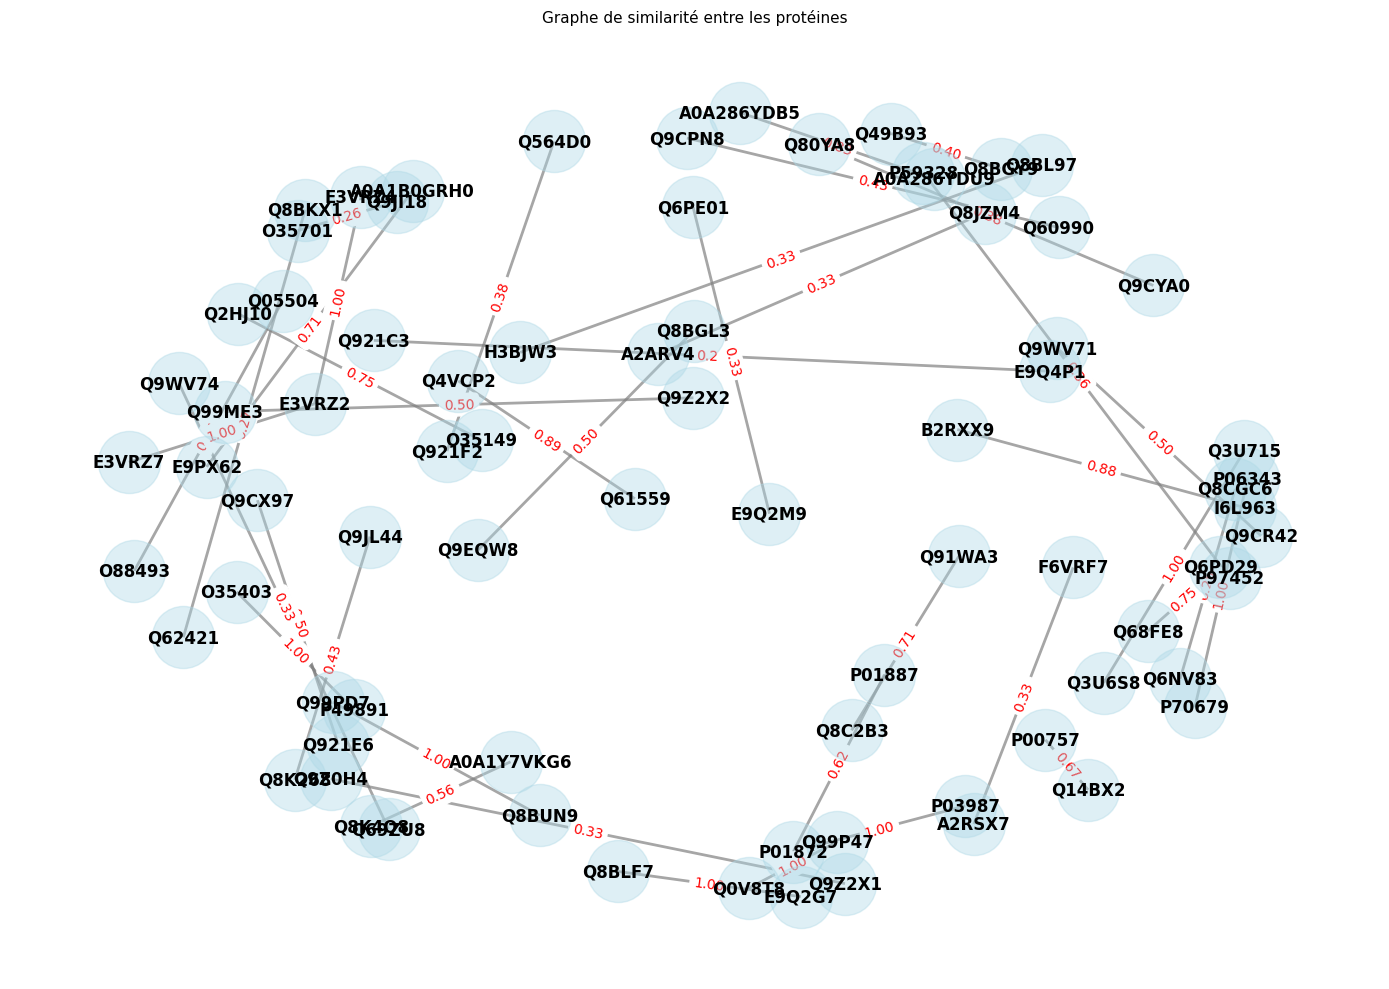

In [173]:
G = nx.Graph()

for edge in test:
    protein1, protein2, similarity = edge
    G.add_edge(protein1, protein2, weight=similarity)


pos = nx.spring_layout(G, k=0.5, iterations=40)

plt.figure(figsize=(14, 10))

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.4)
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', font_family='sans-serif')

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

plt.title("Graphe de similarité entre les protéines", fontsize=11)
plt.axis('off')
plt.tight_layout()
plt.show()


In [101]:
spark.stop()